In [163]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Normalizer

In [164]:
#load the data
data = pd.read_csv('autoscout24.csv', sep=';')

In [165]:
data.head()

,mileage,make,model,fuel,gear,offerType,price,hp,year of sale
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,2011
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,2011
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,2011
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,2011
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,2011


In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46405 entries, 0 to 46404
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mileage       46405 non-null  int64  
 1   make          46405 non-null  object 
 2   model         46262 non-null  object 
 3   fuel          46405 non-null  object 
 4   gear          46223 non-null  object 
 5   offerType     46405 non-null  object 
 6   price         46405 non-null  int64  
 7   hp            46376 non-null  float64
 8   year of sale  46405 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.2+ MB


In [167]:
sum_of_all_null_values = data.isnull().sum()[data.isnull().sum() > 0].sum()
print(f'The database has {sum_of_all_null_values} null values')
print(f'This correspond to {sum_of_all_null_values/data.shape[0]*100:.2f}% of the data -> we can drop them for further analysis')

The database has 354 null values
This correspond to 0.76% of the data -> we can drop them for further analysis


# Split dataset in two price categories for more accurate prediction ((rugular) data and luxus)
## + Drop the price outliers

In [168]:
#drup the null values
data = data.dropna()
#drop the price outliers
threshold = 40000
max_price = 500000 #drop outliers
luxury = data[(data['price'] > threshold) & (data['price'] < max_price)]
data = data[data['price'] < threshold]
#reset the index
data.reset_index(drop=True, inplace=True)
data.isnull().sum()
luxury.reset_index(drop=True, inplace=True)
luxury.isnull().sum()

mileage         0
make            0
model           0
fuel            0
gear            0
offerType       0
price           0
hp              0
year of sale    0
dtype: int64

In [169]:
data.columns

Index(['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'price', 'hp',
       'year of sale'],
      dtype='object')

In [170]:
data.shape, luxury.shape

((43510, 9), (2558, 9))

In [171]:
# Change the categorical data to numerical data
dummy_data = pd.get_dummies(data=data, columns=["make","model","fuel","gear","offerType"])

In [172]:
dummy_luxury = pd.get_dummies(data=luxury, columns=["make","model","fuel","gear","offerType"])

In [173]:
# scale the data of the columns "mileage","hp","year of sale"
scale_data = dummy_data[["mileage","hp","year of sale"]]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(scale_data)
scaled_data = pd.DataFrame(scaled_data, columns=["mileage","hp","year of sale"])

In [174]:
scale_luxury = dummy_luxury[["mileage","hp","year of sale"]]
scaler = StandardScaler()
scaled_luxury = scaler.fit_transform(scale_luxury)
scaled_luxury = pd.DataFrame(scaled_luxury, columns=["mileage","hp","year of sale"])

In [175]:
# concatenate the scaled data with the dummy data
data = pd.concat([scaled_data, dummy_data.drop(columns=["mileage","hp","year of sale"])], axis=1)

In [176]:
luxury = pd.concat([scaled_luxury, dummy_luxury.drop(columns=["mileage","hp","year of sale"])], axis=1)

In [177]:
data.head()

,mileage,hp,year of sale,price,make_Abarth,make_Aixam,make_Alfa,make_Alpina,make_Audi,make_BMW,...,fuel_LPG,fuel_Others,gear_Automatic,gear_Manual,gear_Semi-automatic,offerType_Demonstration,offerType_Employee's car,offerType_New,offerType_Pre-registered,offerType_Used
0,2.564155,-0.110223,-1.548478,6800,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
1,0.299555,0.007010,-1.548478,6877,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
2,1.199343,0.749484,-1.548478,6900,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
3,0.353701,-0.227456,-1.548478,6950,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
4,1.306044,0.671329,-1.548478,6950,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True


<Axes: >

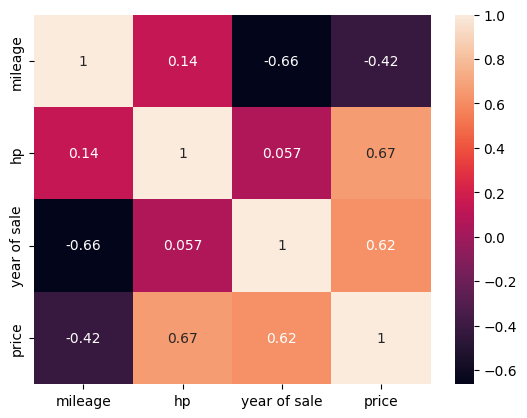

In [178]:
sns.heatmap(data[["mileage","hp","year of sale","price"]].corr(), annot=True)

<Axes: >

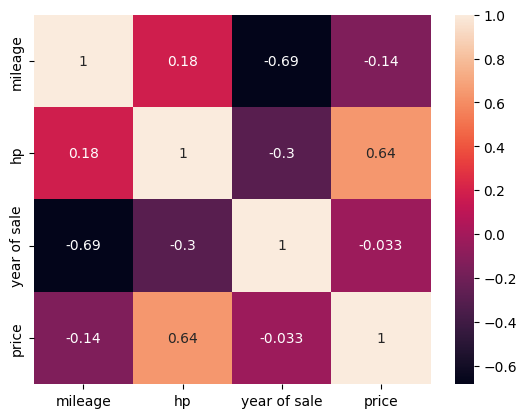

In [179]:
sns.heatmap(luxury[["mileage","hp","year of sale","price"]].corr(), annot=True)

<Axes: xlabel='price', ylabel='Count'>

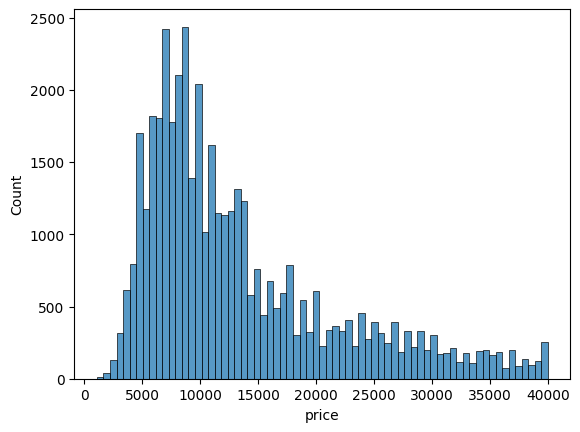

In [180]:
sns.histplot(data["price"])

<Axes: xlabel='price', ylabel='Count'>

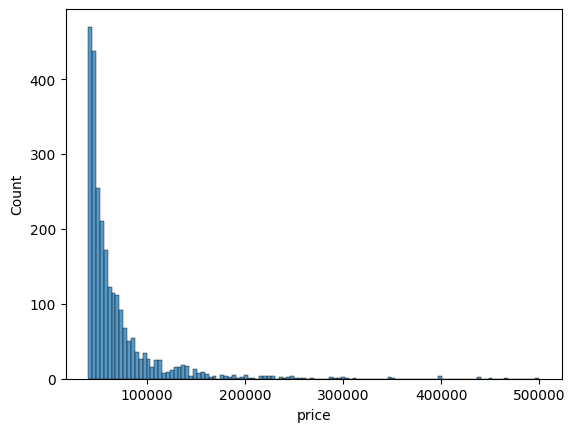

In [181]:
sns.histplot(luxury["price"])

# ML Lienar Regression and Random Forst

In [182]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV

In [183]:
#Train Test Split
X = data.drop(columns=["price"])
y = data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [184]:
#Train Test Split
X_l = luxury.drop(columns=["price"])
y_l = luxury["price"]
X_l_train, X_l_test, y_l_train, y_l_test = train_test_split(X_l, y_l, test_size=0.2, random_state=42)

In [185]:
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)

LinearRegression()

In [186]:
lr_y_pred = lr_clf.predict(X_test)
print(f'Results for the normal data with Linear Regression: ')
print(f'Mean Squared Error: {mean_squared_error(y_test, lr_y_pred)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, lr_y_pred)}')
print(f'R2 Score: {r2_score(y_test, lr_y_pred)}')

Results for the normal data with Linear Regression: 
Mean Squared Error: 6402021.195186744
Mean Absolute Error: 1857.4462544417381
R2 Score: 0.9119965836637323


# With the Threshold on 40k the Linear Regression Model provide solid predictions

Text(0, 0.5, 'Predicted Value')

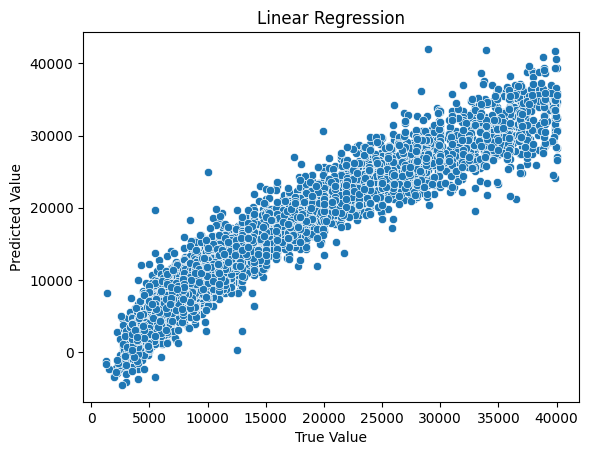

In [187]:
sns.scatterplot(x=y_test, y=lr_y_pred)
plt.title('Linear Regression')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')

In [188]:
rf_clf = RandomForestRegressor()
rf_clf.fit(X_train, y_train)
y_rf_pred = rf_clf.predict(X_test)
print(f'Results for the normal data with Random Forest: ')
print(f'Mean Squared Error: {mean_squared_error(y_test, y_rf_pred)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_rf_pred)}')
print(f'R2 Score: {r2_score(y_test, y_rf_pred)}')

Results for the normal data with Random Forest: 
Mean Squared Error: 4043565.567756753
Mean Absolute Error: 1312.741149388264
R2 Score: 0.9444163689414473


In [189]:
rf_clf_l = RandomForestRegressor()
rf_clf_l.fit(X_l_train, y_l_train)
y_l_rf_pred = rf_clf_l.predict(X_l_test)
print(f'Results for the luxury data with Random Forest: ')
print(f'Mean Squared Error: {mean_squared_error(y_l_test, y_l_rf_pred)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_l_test, y_l_rf_pred)}')
print(f'R2 Score: {r2_score(y_l_test, y_l_rf_pred)}')

Results for the luxury data with Random Forest: 
Mean Squared Error: 189237561.37764925
Mean Absolute Error: 7734.11075462954
R2 Score: 0.8757294322769448


Text(0, 0.5, 'Predicted Value')

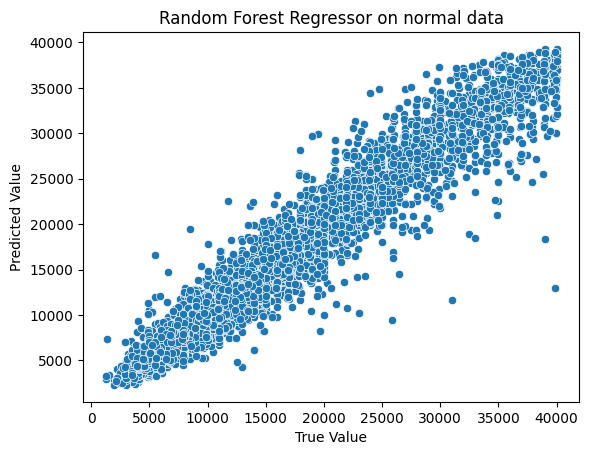

In [190]:
sns.scatterplot(x=y_test, y=y_rf_pred)
plt.title('Random Forest Regressor on normal data')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')

Text(0, 0.5, 'Predicted Value')

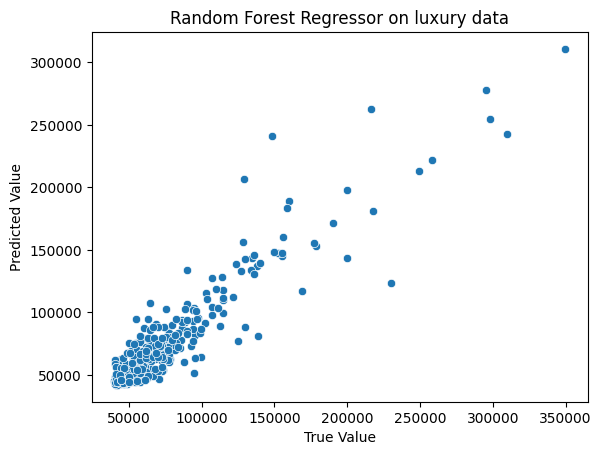

In [191]:
sns.scatterplot(x=y_l_test, y=y_l_rf_pred)
plt.title('Random Forest Regressor on luxury data')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')

# Hyperparametertuning
Tryed in a previous run of this Notebook to Hypertune the RF_Model for even better prediction. 
The R2-Score increesed by 0.01% but it took my PC 3h for Calculation -> So the folowing Codecells are not executed on this updatet Data.

In [162]:
# make a dictionary of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200],
    'max_features': [1.0,'sqrt', 'log2'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [24]:
gs_model = GridSearchCV(estimator=rf_clf,
                        param_grid=param_grid,
                        cv=5, n_jobs=-1,
                        verbose=2, 
                        scoring='neg_mean_squared_error'
                        )
gs_model.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': [1.0, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [25]:
print("Beste Parameter:", gs_model.best_params_)  # Gibt die besten gefundenen Parameter aus
print("Bester Kreuzvalidierungs-Score: {:.2f}".format(gs_model.best_score_))  # Gibt den besten Score aus

# Vorhersagen mit dem besten Modell
best_model = gs_model.best_estimator_  # Zieht sich direkt das beste Modell aus
y_pred = best_model.predict(X_test)  # Vorhersagen auf den Testdaten

print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}')
print(f'R2 Score: {r2_score(y_test, y_pred)}')

Beste Parameter: {'max_depth': 30, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Bester Kreuzvalidierungs-Score: -6344536.49
Mean Squared Error: 6319382.224719596
Mean Absolute Error: 1504.8353140518698
R2 Score: 0.94307448272454


Text(0, 0.5, 'Predicted Value')

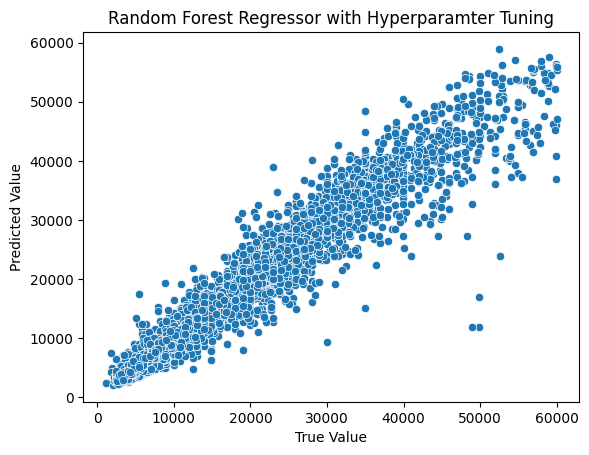

In [28]:
sns.scatterplot(x=y_test, y=y_rf_pred)
plt.title('Random Forest Regressor with Hyperparamter Tuning')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')